In [40]:
from IPython.display import FileLink
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#sampling
from sklearn.utils import resample
#automl
import h2o
from h2o.automl import H2OAutoML
#ml pre
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold
#ml library
from catboost import Pool, cv, CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgbm
#ml eval
from sklearn.metrics import classification_report, roc_auc_score
#tune
import hyperopt
#explain
import shap
shap.initjs()


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/widsdatathon2020/unlabeled.csv
/kaggle/input/widsdatathon2020/solution_template.csv
/kaggle/input/widsdatathon2020/training_v2.csv
/kaggle/input/widsdatathon2020/WiDS Datathon 2020 Dictionary.csv
/kaggle/input/widsdatathon2020/samplesubmission.csv


In [41]:
training_v2 = pd.read_csv("../input/widsdatathon2020/training_v2.csv")
testing = pd.read_csv("../input/widsdatathon2020/unlabeled.csv")

In [3]:
training_v2.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [4]:
training_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [5]:
training_v2['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

# Preprocess & EDA

Identify all the categorical columns

In [42]:
def sep_categorical(df):
    df_cat = df.select_dtypes(exclude=np.float)
    df_num = df.select_dtypes(include=np.float)
    return df_cat, df_num

In [43]:
df_cat, df_num = sep_categorical(training_v2)

In [44]:
df_num[:10].shape

(91713, 170)

remove the col with little overlap between training and testing

In [26]:
useless_col = ['h1_calcium_min' ,'encounter_id', 'patient_id','icu_id']

In [48]:
x = training_v2.drop(['hospital_death'],axis=1)
y = training_v2['hospital_death']

In [ ]:
threshold = 0.9
corr_matrix = x.corr().abs()
corr_matrix.head()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
#Drop the columns with high correlations
to_drop

In [46]:
def simple_impute(df):
    return df.fillna(-99)

In [49]:
def pre_process(df, cat_colnames, useless_col):
    #remove cols
    df = df.drop(useless_col, axis=1)
    df_cat, df_num = sep_categorical(df)
    df_cat = simple_impute(df_cat)
    df_num = simple_impute(df_num)
    selector = VarianceThreshold()
    df_num=pd.DataFrame(selector.fit_transform(df_num), columns=df_num.columns)
    df_processed = pd.concat([df_num, df_cat],axis=1, sort=False)
    return df_processed

x = pre_process(x, cat_colnames, useless_col)

In [32]:
x.shape

(91713, 181)

Check missing data

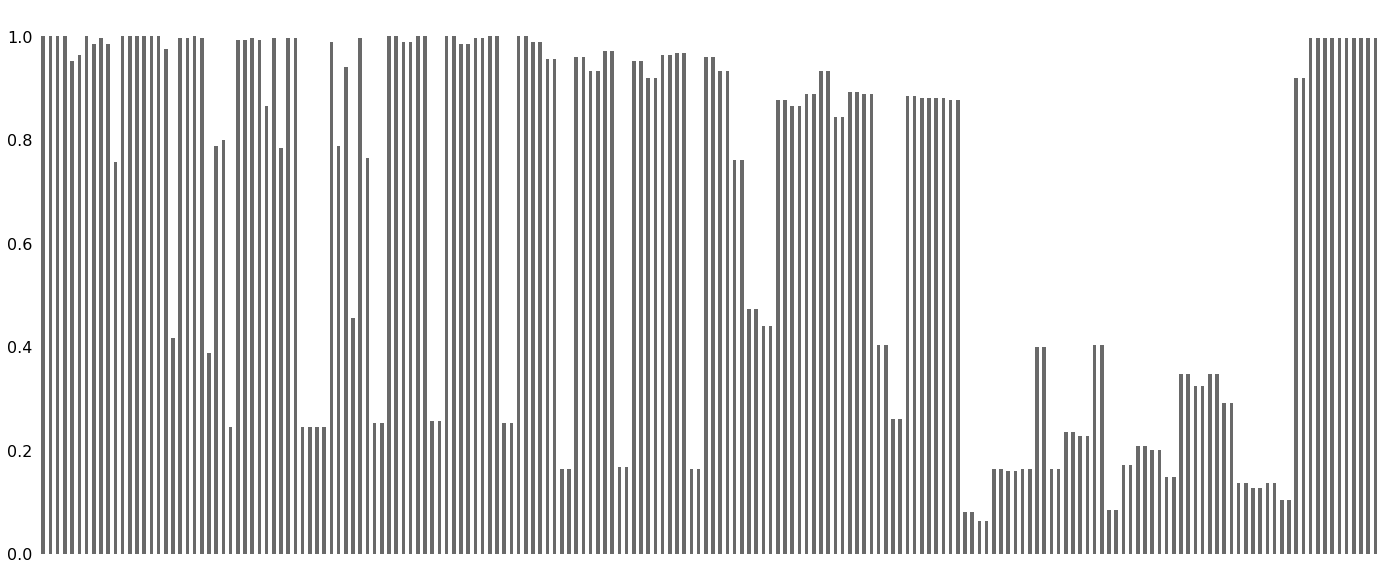

In [35]:
import missingno as msno
msno.bar(training_v2.sample(250))

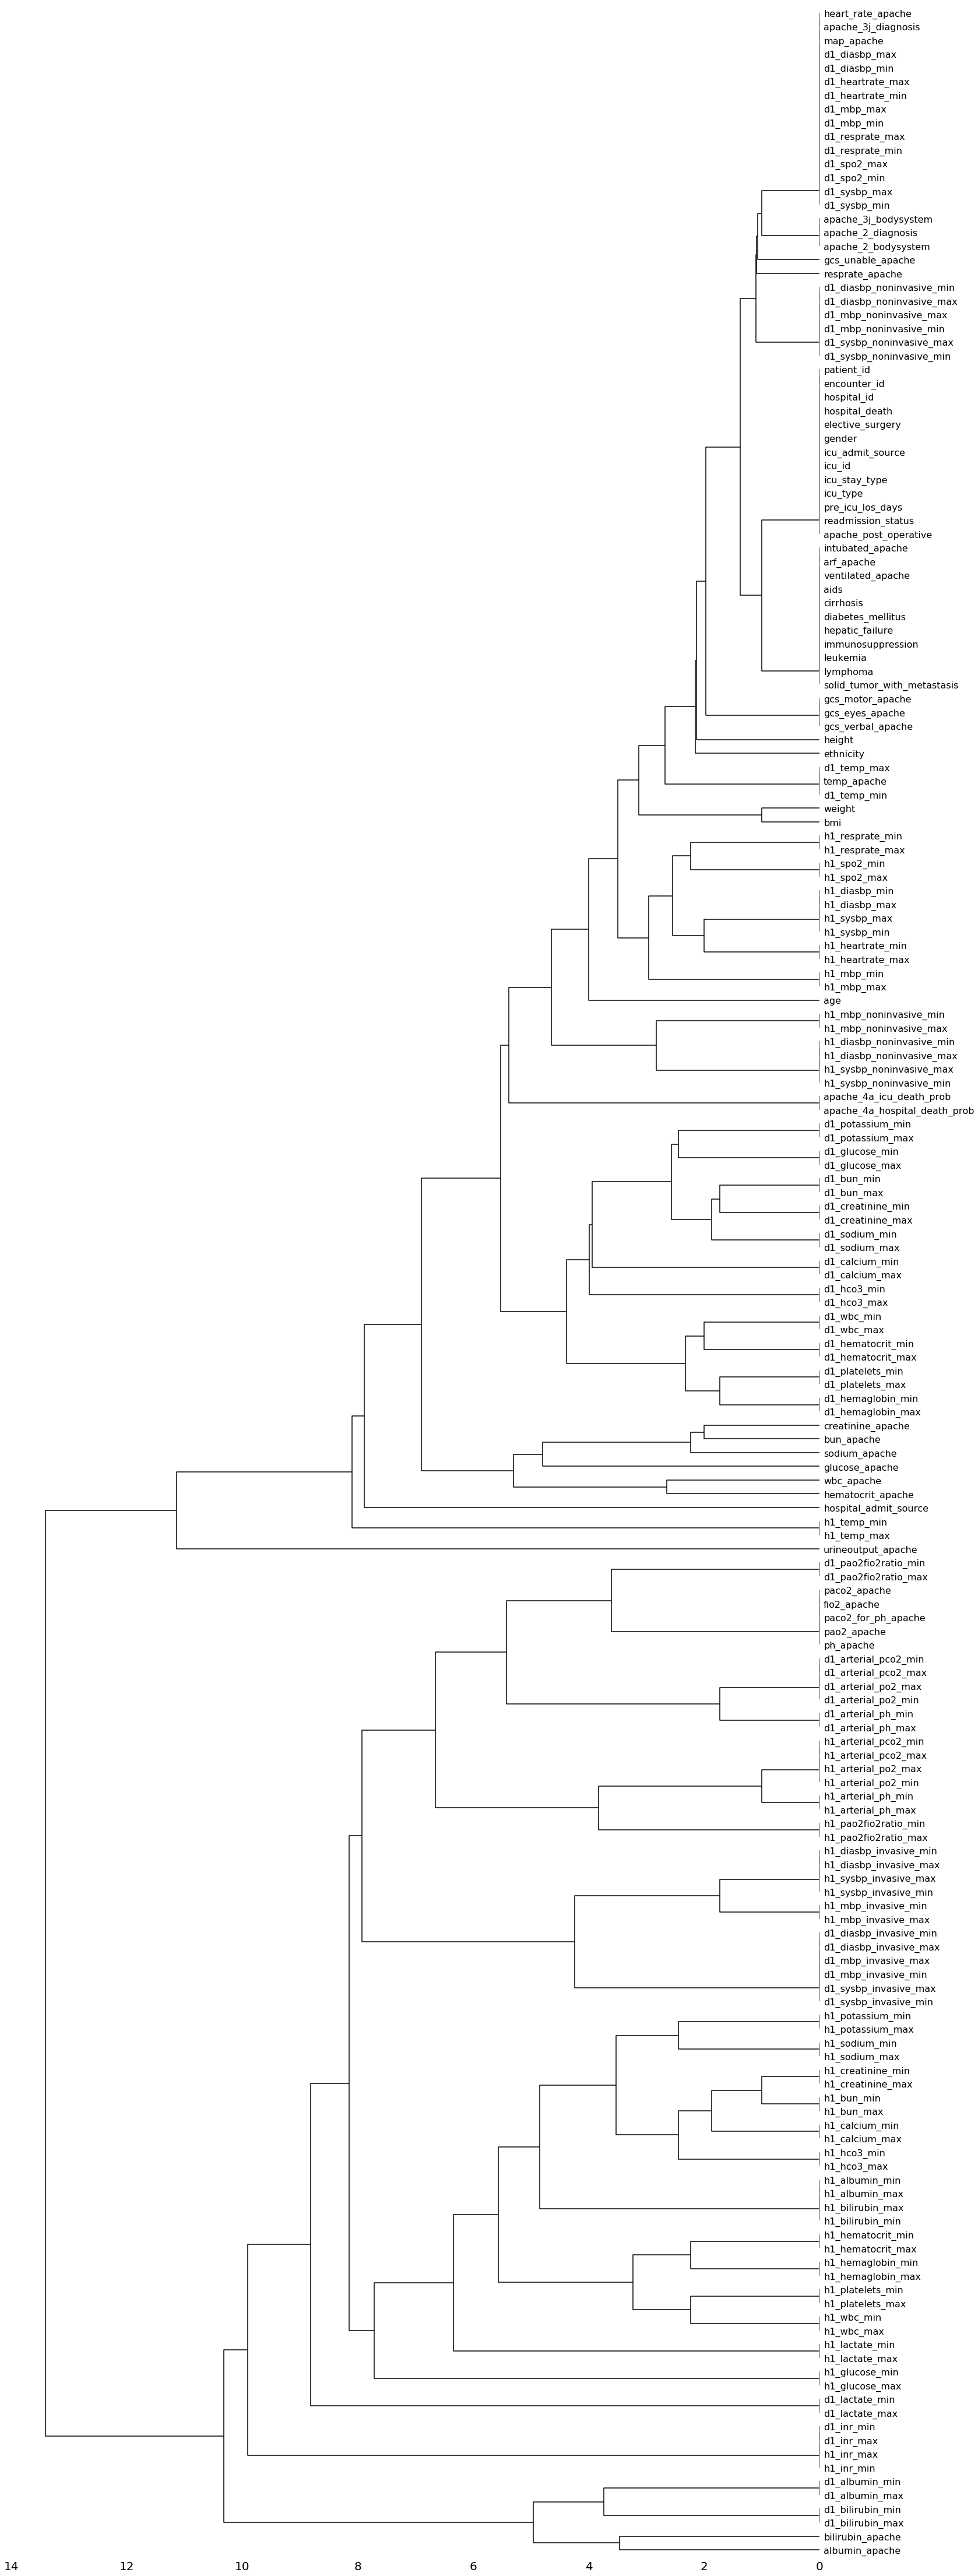

In [45]:
msno.dendrogram(training_v2.sample(250))

# CatBoost

In [ ]:
categorical_features_indices = np.where(x.dtypes != np.float)[0]
categorical_features_indices

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=123)

In [ ]:
params = {
    'iterations': 1000,
    'depth': 7,
    'learning_rate': 0.04,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'early_stopping_rounds': 20,
    'ctr_leaf_count_limit':100
}

clf = CatBoostClassifier(**params)

train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

clf.fit(train_pool, eval_set=validate_pool, plot=True, verbose=False)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
val_cat = clf.predict_proba(X_test)[:,1]
roc_auc_score(np.array(y_test), val_cat)

## feature importance

In [ ]:
clf.get_feature_importance(prettified = True).tail(20)

## logloss feature importance

In [ ]:
np.array(clf.get_feature_importance(train_pool, "LossFunctionChange", prettified=True))

## Prediction

In [ ]:
test_processed = pre_process(testing, cat_colnames, useless_col)
df_test = test_processed.drop('hospital_death',axis=1).fillna(-999)
pred_catboost = clf.predict(df_test,prediction_type='Probability')[:,1]
pred_catboost

# RF

In [ ]:
def process_to_num(x):
    df_object = pd.concat([x.select_dtypes(exclude=np.float), \
                          x[cat_colnames].apply(lambda x: x.astype('object'))], axis=1).fillna(-99)
    df_obj=df_object.apply(lambda x: x.astype('str')).apply(LabelEncoder().fit_transform)
    df_num = x.select_dtypes(include=np.float).drop(cat_colnames, axis=1).fillna(-99)
    x_processed = pd.concat([df_num, df_obj],axis=1, sort=False)
    return x_processed
x_processed_num = process_to_num(x)

In [ ]:
X_train2, X_test2, y_train2, y_test2= train_test_split(x_processed_num, y, test_size=0.2, random_state=123)

In [ ]:
testing_processed = process_to_num(testing).drop('hospital_death',axis=1).drop(useless_col,axis=1).fillna(-99)

In [ ]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, criterion="entropy", random_state=11)
rf.fit(X_train2, y_train2)
rf_pred = rf.predict_proba(testing_processed)[:,1]
rf_pred

In [ ]:
val_rf = rf.predict_proba(X_test2)[:,1]
roc_auc_score(np.array(y_test), val_rf)

# XGB

In [ ]:
params = {"objective": "binary:logistic",
          "eta": 0.15,
          "max_depth": 7,
          "min_child_weight": 10,
          "silent": 1,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "seed": 1}
num_trees=300
gbm = xgb.train(params, xgb.DMatrix(X_train2, y_train2), num_trees)

In [ ]:
val_gbm = gbm.predict(xgb.DMatrix(X_test2))
roc_auc_score(np.array(y_test2), val_gbm)

In [ ]:
gbm_pred = gbm.predict(xgb.DMatrix(testing_processed))
gbm_pred

# LGBM

In [ ]:
train_data=lgbm.Dataset(X_train2,label=y_train2)
param = {
    'num_leaves':170, 
    'objective':'binary',
    'max_depth':7,
    'max_bin':200,
    'boosting': 'gbdt',
     'metric': 'auc',
     'num_leaves': 15,
     'min_data_in_leaf': 90,
     'learning_rate': 0.01,
     'feature_fraction': 0.1,
     'bagging_freq': 1,
     'bagging_fraction': 0.75,
     'use_missing': True,
     'nthread': 4
}
param['metric'] = ['auc']
num_rounds = 2000
clf_lgbm=lgbm.train(param,train_data,num_rounds)

In [ ]:
val_lgbm = clf_lgbm.predict(X_test2)
roc_auc_score(np.array(y_test2),val_lgbm)

In [ ]:
pred_lgbm = clf_lgbm.predict(testing_processed)

### Combine 4 models

In [ ]:
val_concat = np.c_[val_cat, val_lgbm, val_gbm, val_rf]
val_concat.shape

In [ ]:
x_val_pred = pd.DataFrame(val_concat)
lm = LinearRegression().fit(x_val_pred, y_test)
lm.coef_

# Ensemble

In [ ]:
c1, c2, c3, c4 = lm.coef_
pred_en = c1 * pred_catboost + c2 * pred_lgbm + c3 * gbm_pred + c4 * rf_pred
pred_en

In [ ]:
#pred_en = (pred_catboost + rf_pred[:,1] + gbm_pred)/3
df_pred = pd.DataFrame(pred_en)
df_concat = pd.concat([testing["encounter_id"], df_pred], axis=1)
df_concat.columns = ['encounter_id', 'hospital_death']
df_concat.head()